<a href="https://colab.research.google.com/github/isshii/de4test/blob/test_ozawa/DeepXplore/DeepXplore_03_06_coverage_dependence_per_neuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 共通で使うパスなどの定義
# 共通の変数設定
# 共通フォルダパス

import datetime
import pytz
dt_now = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
dt_str = str(dt_now.strftime('%Y%m%d_%H%M'))

data_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data"
#data_imagenet = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet"
data_mnist = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/MNIST"
#data_imagenet_seeds = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds"
model_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/model"
#output_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/output"
output_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/output/" + dt_str
tmp_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/tmp"


In [2]:
# Goggle Drive つなぐ
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# outputフォルダ内容物のクリーンアップ削除
!mkdir "$output_dir"
!rm "$output_dir"/*

rm: cannot remove '/content/gdrive/My Drive/ColabNotebooks/test4ai/output/20191226_2228/*': No such file or directory


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/ColabNotebooks/test4ai/model/MNIST')

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [5]:
import argparse
import pandas as pd

%tensorflow_version 1.x
from keras.datasets import mnist
from keras.layers import Input
import imageio

from __future__ import print_function

from keras.datasets import mnist
from keras.layers import Convolution2D, MaxPooling2D, Input, Dense, Activation, Flatten
from keras.models import Model
from keras.utils import to_categorical
import os

Using TensorFlow backend.


In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14640310725190579065, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8778016146651625765
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4263123365289240808
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15956161332
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8119542745455481165
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [7]:
#@title デフォルトのタイトル テキスト
# DeepXplore のパラメータ設定部
# read the parameter
# argument parsing
parser = argparse.ArgumentParser(description='Main function for difference-inducing input generation in MNIST dataset')
parser.add_argument('transformation', help="realistic transformation type", choices=['light', 'occl', 'blackout'])
parser.add_argument('weight_diff', help="weight hyperparm to control differential behavior", type=float)
parser.add_argument('weight_nc', help="weight hyperparm to control neuron coverage", type=float)
parser.add_argument('step', help="step size of gradient descent", type=float)
parser.add_argument('seeds', help="number of seeds of input", type=int)
parser.add_argument('grad_iterations', help="number of iterations of gradient descent", type=int)
parser.add_argument('threshold', help="threshold for determining neuron activated", type=float)
parser.add_argument('-t', '--target_model', help="target model that we want it predicts differently",
                    choices=[0, 1, 2], default=0, type=int)
parser.add_argument('-sp', '--start_point', help="occlusion upper left corner coordinate", default=(0, 0), type=tuple)
parser.add_argument('-occl_size', '--occlusion_size', help="occlusion size", default=(10, 10), type=tuple)

_StoreAction(option_strings=['-occl_size', '--occlusion_size'], dest='occlusion_size', nargs=None, const=None, default=(10, 10), type=<class 'tuple'>, choices=None, help='occlusion size', metavar=None)

In [0]:
#@title ノイズのタイプ light / occl / blackout
#@body {light,occl,blackout} weight_diff weight_nc step seeds
#                   grad_iterations threshold
noise_type = "light" #@param ["light", "occl", "blackout"]
weight_diff = "0.1" #@param {type:"string"}
weight_nc = "0.1" #@param {type:"string"}
step = "20" #@param {type:"string"}　#50だとほぼ白飛び
seeds = "100" #@param {type:"string"}
grad_iterations = "10" #@param {type:"string"}
threshold = "0.1" #@param {type:"string"}

In [0]:
args = parser.parse_args([noise_type, weight_diff, weight_nc, step, seeds, grad_iterations, threshold])

In [0]:
import random
from collections import defaultdict

import numpy as np
from keras import backend as K
from keras.models import Model


# util function to convert a tensor into a valid image
def deprocess_image(x):
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x.reshape(x.shape[1], x.shape[2])  # original shape (1,img_rows, img_cols,1)


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


def constraint_occl(gradients, start_point, rect_shape):
    new_grads = np.zeros_like(gradients)
    new_grads[:, start_point[0]:start_point[0] + rect_shape[0],
    start_point[1]:start_point[1] + rect_shape[1]] = gradients[:, start_point[0]:start_point[0] + rect_shape[0],
                                                     start_point[1]:start_point[1] + rect_shape[1]]
    return new_grads


def constraint_light(gradients):
    new_grads = np.ones_like(gradients)
    grad_mean = np.mean(gradients)
    return grad_mean * new_grads


def constraint_black(gradients, rect_shape=(6, 6)):
    start_point = (
        random.randint(0, gradients.shape[1] - rect_shape[0]), random.randint(0, gradients.shape[2] - rect_shape[1]))
    new_grads = np.zeros_like(gradients)
    patch = gradients[:, start_point[0]:start_point[0] + rect_shape[0], start_point[1]:start_point[1] + rect_shape[1]]
    if np.mean(patch) < 0:
        new_grads[:, start_point[0]:start_point[0] + rect_shape[0],
        start_point[1]:start_point[1] + rect_shape[1]] = -np.ones_like(patch)
    return new_grads


def init_coverage_tables(model1, model2, model3):
    model_layer_dict1 = defaultdict(bool)
    model_layer_dict2 = defaultdict(bool)
    model_layer_dict3 = defaultdict(bool)
    init_dict(model1, model_layer_dict1)
    init_dict(model2, model_layer_dict2)
    init_dict(model3, model_layer_dict3)
    return model_layer_dict1, model_layer_dict2, model_layer_dict3


def init_dict(model, model_layer_dict):
    for layer in model.layers:
        if 'flatten' in layer.name or 'input' in layer.name:
            continue
        for index in range(layer.output_shape[-1]):
            model_layer_dict[(layer.name, index)] = False


def neuron_to_cover(model_layer_dict):
    not_covered = [(layer_name, index) for (layer_name, index), v in model_layer_dict.items() if not v]
    if not_covered:
        layer_name, index = random.choice(not_covered)
    else:
        layer_name, index = random.choice(model_layer_dict.keys())
    return layer_name, index


def neuron_covered(model_layer_dict):
    covered_neurons = len([v for v in model_layer_dict.values() if v])
    total_neurons = len(model_layer_dict)
    return covered_neurons, total_neurons, covered_neurons / float(total_neurons)


def update_coverage(input_data, model, model_layer_dict, threshold=0):
    layer_names = [layer.name for layer in model.layers if
                   'flatten' not in layer.name and 'input' not in layer.name]

    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=[model.get_layer(layer_name).output for layer_name in layer_names])
    intermediate_layer_outputs = intermediate_layer_model.predict(input_data)

    for i, intermediate_layer_output in enumerate(intermediate_layer_outputs):
        scaled = scale(intermediate_layer_output[0])
        for num_neuron in range(scaled.shape[-1]):
            if np.mean(scaled[..., num_neuron]) > threshold and not model_layer_dict[(layer_names[i], num_neuron)]:
                model_layer_dict[(layer_names[i], num_neuron)] = True


def full_coverage(model_layer_dict):
    if False in model_layer_dict.values():
        return False
    return True


def scale(intermediate_layer_output, rmax=1, rmin=0):
    X_std = (intermediate_layer_output - intermediate_layer_output.min()) / (
        intermediate_layer_output.max() - intermediate_layer_output.min())
    X_scaled = X_std * (rmax - rmin) + rmin
    return X_scaled


def fired(model, layer_name, index, input_data, threshold=0):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    intermediate_layer_output = intermediate_layer_model.predict(input_data)[0]
    scaled = scale(intermediate_layer_output)
    if np.mean(scaled[..., index]) > threshold:
        return True
    return False


def diverged(predictions1, predictions2, predictions3, target):
    #     if predictions2 == predictions3 == target and predictions1 != target:
    if not predictions1 == predictions2 == predictions3:
        return True
    return False


#add
def list_pictures(directory, ext='jpg|jpeg|bmp|png|ppm'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if re.match(r'([\w]+\.(?:' + ext + '))', f.lower())]

In [11]:
# input image dimensions
img_rows, img_cols = 28, 28
# the data, shuffled and split between train and test sets
(_, _), (x_test, _) = mnist.load_data()

x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_test = x_test.astype('float32')
x_test /= 255

# define input tensor as a placeholder
input_tensor = Input(shape=input_shape)

In [12]:
'''
LeNet-1
'''
def Model1(input_tensor=None, train=False):
    nb_classes = 10
    # convolution kernel size
    kernel_size = (5, 5)

    if train:
        batch_size = 256
        nb_epoch = 10

        # input image dimensions
        img_rows, img_cols = 28, 28

        # the data, shuffled and split between train and test sets
        (x_train, y_train), (x_test, y_test) = mnist.load_data()

        print(x_train.shape)
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255

        # convert class vectors to binary class matrices
        y_train = to_categorical(y_train, nb_classes)
        y_test = to_categorical(y_test, nb_classes)

        input_tensor = Input(shape=input_shape)
    elif input_tensor is None:
        print(bcolors.FAIL + 'you have to proved input_tensor when testing')
        exit()

    # block1
    x = Convolution2D(4, kernel_size, activation='relu', padding='same', name='block1_conv1')(input_tensor)
    x = MaxPooling2D(pool_size=(2, 2), name='block1_pool1')(x)

    # block2
    x = Convolution2D(12, kernel_size, activation='relu', padding='same', name='block2_conv1')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='block2_pool1')(x)

    x = Flatten(name='flatten')(x)
    x = Dense(nb_classes, name='before_softmax')(x)
    x = Activation('softmax', name='predictions')(x)

    model = Model(input_tensor, x)

    if train:
        # compiling
        model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

        # trainig
        model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=nb_epoch, verbose=1)
        # save model
#        model.save_weights('./Model1.h5')
        model.save_weights('/content/gdrive/My Drive/ColabNotebooks/test4ai/model/MNIST/Model1.h5')
        score = model.evaluate(x_test, y_test, verbose=0)
        print('\n')
        print('Overall Test score:', score[0])
        print('Overall Test accuracy:', score[1])
    else:
#        model.load_weights('./Model1.h5')
        model.load_weights('/content/gdrive/My Drive/ColabNotebooks/test4ai/model/MNIST/Model1.h5')
        print(bcolors.OKBLUE + 'Model1 loaded' + bcolors.ENDC)

    return model


if __name__ == '__main__':
    Model1(train=True)


(60000, 28, 28)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 60000 samples, validate on 10000 samples
Epoch 1/10





60000/60000 [==============================] - 4s 59us/step - loss: 0.4919 - acc: 0.8460 - val_loss: 0.1298 - val_acc: 0.9600
Epoch 2/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.1175 - acc: 0.9648 - val_loss: 0.1032 - val_acc: 0.9688
Epoch 3/10
60000/60000 [==============================] - 1s 20us/step - loss: 0.0851 - acc: 0.9740 - val_loss: 0.0660 - val_acc: 0.9794
Epoch 4/10
60000/60000 [==============================] - 1s 20us/step - loss: 0.0699 - acc: 0.9792 - val_loss: 0.0614 - val_acc: 0.9806
Epoch 5/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.0606 - acc: 0.9819 - val_loss: 0.0533 - val_acc: 0.9829
Epoch 6/10
60000/60000 [==============================] - 1s 21us/step - loss: 0.0544 - acc: 0.9836 - val_loss: 0.0560 - val_acc: 0.9818
Epoch 

In [13]:
'''
LeNet-4
'''
def Model2(input_tensor=None, train=False):
    nb_classes = 10
    # convolution kernel size
    kernel_size = (5, 5)

    if train:
        batch_size = 256
        nb_epoch = 10

        # input image dimensions
        img_rows, img_cols = 28, 28

        # the data, shuffled and split between train and test sets
        (x_train, y_train), (x_test, y_test) = mnist.load_data()

        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255

        # convert class vectors to binary class matrices
        y_train = to_categorical(y_train, nb_classes)
        y_test = to_categorical(y_test, nb_classes)

        input_tensor = Input(shape=input_shape)
    elif input_tensor is None:
        print(bcolors.FAIL + 'you have to proved input_tensor when testing')
        exit()

    # block1
    x = Convolution2D(6, kernel_size, activation='relu', padding='same', name='block1_conv1')(input_tensor)
    x = MaxPooling2D(pool_size=(2, 2), name='block1_pool1')(x)

    # block2
    x = Convolution2D(16, kernel_size, activation='relu', padding='same', name='block2_conv1')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='block2_pool1')(x)

    x = Flatten(name='flatten')(x)
    x = Dense(84, activation='relu', name='fc1')(x)
    x = Dense(nb_classes, name='before_softmax')(x)
    x = Activation('softmax', name='predictions')(x)

    model = Model(input_tensor, x)

    if train:
        # compiling
        model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

        # trainig
        model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=nb_epoch, verbose=1)
        # save model
        model.save_weights('./Model2.h5')
        score = model.evaluate(x_test, y_test, verbose=0)
        print('\n')
        print('Overall Test score:', score[0])
        print('Overall Test accuracy:', score[1])
    else:
        model.load_weights('./Model2.h5')
        print(bcolors.OKBLUE + 'Model2 loaded' + bcolors.ENDC)

    return model


if __name__ == '__main__':
    Model2(train=True)


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.3593 - acc: 0.8900 - val_loss: 0.0933 - val_acc: 0.9729
Epoch 2/10
60000/60000 [==============================] - 1s 23us/step - loss: 0.0810 - acc: 0.9755 - val_loss: 0.0681 - val_acc: 0.9789
Epoch 3/10
60000/60000 [==============================] - 1s 23us/step - loss: 0.0587 - acc: 0.9819 - val_loss: 0.0945 - val_acc: 0.9684
Epoch 4/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.0467 - acc: 0.9853 - val_loss: 0.0479 - val_acc: 0.9845
Epoch 5/10
60000/60000 [==============================] - 1s 23us/step - loss: 0.0402 - acc: 0.9877 - val_loss: 0.0381 - val_acc: 0.9861
Epoch 6/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.0334 - acc: 0.9897 - val_loss: 0.0447 - val_acc: 0.9846
Epoch 7/10
60000/60000 [==============================] - 1s 22us/step - loss: 0.0293 - acc: 0.9907 - val_loss: 0.0389 - val_acc

In [14]:
'''
LeNet-5
'''
def Model3(input_tensor=None, train=False):
    nb_classes = 10
    # convolution kernel size
    kernel_size = (5, 5)

    if train:
        batch_size = 256
        nb_epoch = 10

        # input image dimensions
        img_rows, img_cols = 28, 28

        # the data, shuffled and split between train and test sets
        (x_train, y_train), (x_test, y_test) = mnist.load_data()

        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255

        # convert class vectors to binary class matrices
        y_train = to_categorical(y_train, nb_classes)
        y_test = to_categorical(y_test, nb_classes)

        input_tensor = Input(shape=input_shape)
    elif input_tensor is None:
        print(bcolors.FAIL + 'you have to proved input_tensor when testing')
        exit()

    # block1
    x = Convolution2D(6, kernel_size, activation='relu', padding='same', name='block1_conv1')(input_tensor)
    x = MaxPooling2D(pool_size=(2, 2), name='block1_pool1')(x)

    # block2
    x = Convolution2D(16, kernel_size, activation='relu', padding='same', name='block2_conv1')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='block2_pool1')(x)

    x = Flatten(name='flatten')(x)
    x = Dense(120, activation='relu', name='fc1')(x)
    x = Dense(84, activation='relu', name='fc2')(x)
    x = Dense(nb_classes, name='before_softmax')(x)
    x = Activation('softmax', name='predictions')(x)

    model = Model(input_tensor, x)

    if train:
        # compiling
        model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

        # trainig
        model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=nb_epoch, verbose=1)
        # save model
        model.save_weights('./Model3.h5')
        score = model.evaluate(x_test, y_test, verbose=0)
        print('\n')
        print('Overall Test score:', score[0])
        print('Overall Test accuracy:', score[1])
    else:
        model.load_weights('./Model3.h5')
        print(bcolors.OKBLUE + 'Model3 loaded' + bcolors.ENDC)

    return model


if __name__ == '__main__':
    Model3(train=True)


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 31us/step - loss: 0.3843 - acc: 0.8777 - val_loss: 0.1173 - val_acc: 0.9606
Epoch 2/10
60000/60000 [==============================] - 1s 24us/step - loss: 0.0791 - acc: 0.9750 - val_loss: 0.0555 - val_acc: 0.9817
Epoch 3/10
60000/60000 [==============================] - 1s 24us/step - loss: 0.0558 - acc: 0.9823 - val_loss: 0.0481 - val_acc: 0.9845
Epoch 4/10
60000/60000 [==============================] - 1s 24us/step - loss: 0.0424 - acc: 0.9863 - val_loss: 0.0396 - val_acc: 0.9863
Epoch 5/10
60000/60000 [==============================] - 1s 24us/step - loss: 0.0333 - acc: 0.9894 - val_loss: 0.0362 - val_acc: 0.9873
Epoch 6/10
60000/60000 [==============================] - 2s 25us/step - loss: 0.0284 - acc: 0.9911 - val_loss: 0.0672 - val_acc: 0.9779
Epoch 7/10
60000/60000 [==============================] - 1s 24us/step - loss: 0.0240 - acc: 0.9924 - val_loss: 0.0314 - val_acc

In [15]:
model1 = Model1(input_tensor=input_tensor)
model2 = Model2(input_tensor=input_tensor)
model3 = Model3(input_tensor=input_tensor)
model_layer_dict1, model_layer_dict2, model_layer_dict3 = init_coverage_tables(model1, model2, model3)

Model1 loaded
Model2 loaded
Model3 loaded


In [0]:
# start gen inputs
# img_paths = list_pictures(data_imagenet_seeds)

In [17]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
test_per_fig_x = np.array([])
test_per_fig_y = np.array([])
tests_x = np.array([])
tests_y = np.array([])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train = x_train.astype('float')
#x_test = x_test.astype('float')
x_train /= 255
x_test /= 255

length = int(args.seeds/10)
for i in range(10):
  cond = [(x==i) for x in y_test]
  test_per_fig_x = x_test[cond]
  test_per_fig_y = y_test[cond]
  print(i, test_per_fig_x.shape, test_per_fig_x.shape[0]-1000)
  tests_x = np.append(tests_x, test_per_fig_x[:length])
  tests_y = np.append(tests_y, test_per_fig_y[:length])
#  conds = [conds, cond]
print("check!", tests_x.shape[0]/28/28/10, "=", length, "equal?")
tests_x = tests_x.reshape(-1,28,28,1)
#tests_x = tests_x.reshape(-1,1,28,28,1,)
tests_x.shape
tests_x = tests_x.astype('float32')

0 (980, 28, 28) -20
1 (1135, 28, 28) 135
2 (1032, 28, 28) 32
3 (1010, 28, 28) 10
4 (982, 28, 28) -18
5 (892, 28, 28) -108
6 (958, 28, 28) -42
7 (1028, 28, 28) 28
8 (974, 28, 28) -26
9 (1009, 28, 28) 9
check! 10.0 = 10 equal?


In [18]:
x_test.shape

(10000, 28, 28)

In [19]:
%%time


def neuron_output(input_data, model, model_layer_dict, threshold=0):
    layer_names = [layer.name for layer in model.layers if
                   'flatten' not in layer.name and 'input' not in layer.name]

    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=[model.get_layer(layer_name).output for layer_name in layer_names])
    intermediate_layer_outputs = intermediate_layer_model.predict(input_data)
    
    out_list = []
    out_list_scale = []
    for i, intermediate_layer_output in enumerate(intermediate_layer_outputs):
        scaled = scale(intermediate_layer_output[0])
        for num_neuron in range(scaled.shape[-1]):
            out_list.append(np.mean(intermediate_layer_output[..., num_neuron]))
            out_list_scale.append(np.mean(scaled[..., num_neuron]))

    return out_list, out_list_scale


count_already = 0
count_found = 0
count_not_found = 0
temp_per_nc1 = np.array([])
temp_per_nc2 = np.array([])
temp_per_nc3 = np.array([])
temp_num_nc1 = np.array([])
temp_num_nc2 = np.array([])
temp_num_nc3 = np.array([])

#for each neuron
num_neurons1 = neuron_covered(model_layer_dict1)[1]
num_neurons2 = neuron_covered(model_layer_dict2)[1]
num_neurons3 = neuron_covered(model_layer_dict3)[1]

column_tmp1 = list(model_layer_dict1.keys())
column_tmp2 = list(model_layer_dict2.keys())
column_tmp3 = list(model_layer_dict3.keys())
df1 = pd.DataFrame(columns=column_tmp1)
df2 = pd.DataFrame(columns=column_tmp2)
df3 = pd.DataFrame(columns=column_tmp3)
df1_scale = pd.DataFrame(columns=column_tmp1)
df2_scale = pd.DataFrame(columns=column_tmp2)
df3_scale = pd.DataFrame(columns=column_tmp3)
trial = 0

for index_fig in range(10):
  print("figure"+str(index_fig))
  for _ in range(length):
      #gen_img = np.expand_dims(random.choice(tests_x), axis=0)
      gen_img = np.expand_dims(tests_x[(length*index_fig + _)], axis=0)
      orig_img = gen_img.copy()
      # first check if input already induces differences
      label1, label2, label3 = np.argmax(model1.predict(gen_img)[0]), np.argmax(model2.predict(gen_img)[0]), np.argmax(model3.predict(gen_img)[0])

      if not label1 == label2 == label3:
          count_already += 1
          print(bcolors.OKGREEN + '{}/{}. input already causes different outputs ({},{},{}) at{}/{}: '.format(_, length, label1, label2, label3, count_already, count_already + count_found + count_not_found) + bcolors.ENDC)        
          #print(bcolors.OKGREEN + '{}/{}. input already causes different outputs ({},{},{}) at{}/{}: '.format(_, length, label1, label2, label3, count_already, count_already + count_found + count_not_found) + bcolors.ENDC)        

          update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
          update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
          update_coverage(gen_img, model3, model_layer_dict3, args.threshold)

          temp_per_nc1=np.append(temp_per_nc1,  neuron_covered(model_layer_dict1)[2])
          temp_per_nc2=np.append(temp_per_nc2,  neuron_covered(model_layer_dict2)[2])
          temp_per_nc3=np.append(temp_per_nc3,  neuron_covered(model_layer_dict3)[2])
          temp_num_nc1=np.append(temp_num_nc1,  neuron_covered(model_layer_dict1)[0])
          temp_num_nc2=np.append(temp_num_nc2,  neuron_covered(model_layer_dict2)[0])
          temp_num_nc3=np.append(temp_num_nc3,  neuron_covered(model_layer_dict3)[0])
                               
          print(bcolors.OKGREEN + '     covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'% (len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
                  neuron_covered(model_layer_dict2)[2], len(model_layer_dict3), neuron_covered(model_layer_dict3)[2]) + bcolors.ENDC)
          averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                       neuron_covered(model_layer_dict3)[0]) / float(neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +neuron_covered(model_layer_dict3)[1])
          print(bcolors.OKGREEN + '     averaged covered neurons %.3f' % (averaged_nc) + bcolors.ENDC)

          gen_img_deprocessed = deprocess_image(gen_img)

          # save the result to disk
          outputfilepath0 = os.path.join(output_dir, 'already_differ_' + str(label1) + '_' + str(label2) + '_' + str(label3) +'_['+ str(_) +  '].png')
          imageio.imwrite(outputfilepath0, gen_img_deprocessed)

          temp, temp_scale = neuron_output(gen_img, model1, model_layer_dict1, args.threshold)
          temp = pd.Series(temp, index=df1.columns, name=str(trial))
          temp_scale = pd.Series(temp_scale, index=df1.columns, name=str(trial))
          df1 = df1.append(temp)
          df1_scale = df1_scale.append(temp_scale)

          temp, temp_scale = neuron_output(gen_img, model2, model_layer_dict2, args.threshold)
          temp = pd.Series(temp, index=df2.columns, name=str(trial))
          temp_scale = pd.Series(temp_scale, index=df2.columns, name=str(trial))
          df2 = df2.append(temp)
          df2_scale = df2_scale.append(temp_scale)

          temp, temp_scale = neuron_output(gen_img, model3, model_layer_dict3, args.threshold)
          temp = pd.Series(temp, index=df3.columns, name=str(trial))
          temp_scale = pd.Series(temp_scale, index=df3.columns, name=str(trial))

          df3 = df3.append(temp)
          df3_scale = df3_scale.append(temp_scale)

          trial += 1
          continue

      # if all label agrees
      orig_label = label1
      layer_name1, index1 = neuron_to_cover(model_layer_dict1)
      layer_name2, index2 = neuron_to_cover(model_layer_dict2)
      layer_name3, index3 = neuron_to_cover(model_layer_dict3)

      # construct joint loss function
      if args.target_model == 0:
        loss1 = -args.weight_diff * K.mean(model1.get_layer('before_softmax').output[..., orig_label])
        loss2 = K.mean(model2.get_layer('before_softmax').output[..., orig_label])
        loss3 = K.mean(model3.get_layer('before_softmax').output[..., orig_label])
      elif args.target_model == 1:
        loss1 = K.mean(model1.get_layer('before_softmax').output[..., orig_label])
        loss2 = -args.weight_diff * K.mean(model2.get_layer('before_softmax').output[..., orig_label])
        loss3 = K.mean(model3.get_layer('before_softmax').output[..., orig_label])
      elif args.target_model == 2:
        loss1 = K.mean(model1.get_layer('before_softmax').output[..., orig_label])
        loss2 = K.mean(model2.get_layer('before_softmax').output[..., orig_label])
        loss3 = -args.weight_diff * K.mean(model3.get_layer('before_softmax').output[..., orig_label])
      loss1_neuron = K.mean(model1.get_layer(layer_name1).output[..., index1])
      loss2_neuron = K.mean(model2.get_layer(layer_name2).output[..., index2])
      loss3_neuron = K.mean(model3.get_layer(layer_name3).output[..., index3])
      layer_output = (loss1 + loss2 + loss3) + args.weight_nc * (loss1_neuron + loss2_neuron + loss3_neuron)

      # for adversarial image generation
      final_loss = K.mean(layer_output)

      # we compute the gradient of the input picture wrt this loss
      grads = normalize(K.gradients(final_loss, input_tensor)[0])

      # this function returns the loss and grads given the input picture
      iterate = K.function([input_tensor], [loss1, loss2, loss3, loss1_neuron, loss2_neuron, loss3_neuron, grads])

      # we run gradient ascent for some steps
      for iters in range(args.grad_iterations):
        loss_value1, loss_value2, loss_value3, loss_neuron1, loss_neuron2, loss_neuron3, grads_value = iterate(
            [gen_img])
        if args.transformation == 'light':
            grads_value = constraint_light(grads_value)  # constraint the gradients value
        elif args.transformation == 'occl':
            grads_value = constraint_occl(grads_value, args.start_point,
                                          args.occlusion_size)  # constraint the gradients value
        elif args.transformation == 'blackout':
            grads_value = constraint_black(grads_value)  # constraint the gradients value

        gen_img += grads_value * args.step
        predictions1 = np.argmax(model1.predict(gen_img)[0])
        predictions2 = np.argmax(model2.predict(gen_img)[0])
        predictions3 = np.argmax(model3.predict(gen_img)[0])

        if not predictions1 == predictions2 == predictions3:
            update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
            update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
            update_coverage(gen_img, model3, model_layer_dict3, args.threshold)
            count_found += 1
            print(bcolors.OKBLUE + '%4d/%d. found at %d! covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f at %d/%d'
#                  % (_, args.seeds, iters, len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
                  % (_, length, iters, len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
                     neuron_covered(model_layer_dict2)[2], len(model_layer_dict3),
                     neuron_covered(model_layer_dict3)[2], count_found, count_already + count_found + count_not_found) + bcolors.ENDC)
            averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                           neuron_covered(model_layer_dict3)[0]) / float(
                neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
                neuron_covered(model_layer_dict3)[1])
            print(bcolors.OKBLUE + '     averaged covered neurons %.3f' % averaged_nc + bcolors.ENDC)

            gen_img_deprocessed = deprocess_image(gen_img)
            orig_img_deprocessed = deprocess_image(orig_img)

            # save the result to disk
            #outputfilepath = os.path.join(output_dir, args.transformation + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '.png')
            outputfilepath = os.path.join(output_dir, args.transformation + '_from' + str(label1) + '_to' + str(predictions1) + '_'  + str(predictions2) + '_' + str(predictions3) +'_['+ str(_) +  '].png')
            #print(outputfilepath)
            imageio.imwrite(outputfilepath, gen_img_deprocessed)
#            outputfilepath2 = os.path.join(output_dir, args.transformation + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_orig.png')
            outputfilepath2 = os.path.join(output_dir, args.transformation + '_from' + str(label1) + '_to' + str(predictions1) + '_'  + str(predictions2) + '_' + str(predictions3) +'_['+ str(_) +  ']_orig.png')
            #print(outputfilepath2)
            imageio.imwrite(outputfilepath2, orig_img_deprocessed)
            temp_per_nc1=np.append(temp_per_nc1,  neuron_covered(model_layer_dict1)[2])
            temp_per_nc2=np.append(temp_per_nc2,  neuron_covered(model_layer_dict2)[2])
            temp_per_nc3=np.append(temp_per_nc3,  neuron_covered(model_layer_dict3)[2])
            temp_num_nc1=np.append(temp_num_nc1,  neuron_covered(model_layer_dict1)[0])
            temp_num_nc2=np.append(temp_num_nc2,  neuron_covered(model_layer_dict2)[0])
            temp_num_nc3=np.append(temp_num_nc3,  neuron_covered(model_layer_dict3)[0])

            temp, temp_scale = neuron_output(gen_img, model1, model_layer_dict1, args.threshold)
            temp = pd.Series(temp, index=df1.columns, name=str(trial))
            temp_scale = pd.Series(temp_scale, index=df1.columns, name=str(trial))
            df1 = df1.append(temp)
            df1_scale = df1_scale.append(temp_scale)

            temp, temp_scale = neuron_output(gen_img, model2, model_layer_dict2, args.threshold)
            temp = pd.Series(temp, index=df2.columns, name=str(trial))
            temp_scale = pd.Series(temp_scale, index=df2.columns, name=str(trial))
            df2 = df2.append(temp)
            df2_scale = df2_scale.append(temp_scale)

            temp, temp_scale = neuron_output(gen_img, model3, model_layer_dict3, args.threshold)
            temp = pd.Series(temp, index=df3.columns, name=str(trial))
            temp_scale = pd.Series(temp_scale, index=df3.columns, name=str(trial))

            df3 = df3.append(temp)
            df3_scale = df3_scale.append(temp_scale)

            trial += 1
            break
          
          #add
        if iters == (args.grad_iterations-1):
            update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
            update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
            update_coverage(gen_img, model3, model_layer_dict3, args.threshold)
            averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                           neuron_covered(model_layer_dict3)[0]) / float(neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
                neuron_covered(model_layer_dict3)[1])
            count_not_found += 1
#              print('%4d/%d. test suite was not found: averaged covered neurons %.3f at %d/%d' % (_, args.seeds, averaged_nc, count_not_found, count_already + count_found + count_not_found))
            print('%4d/%d. test suite was not found: averaged covered neurons %.3f at %d/%d' % (_, length, averaged_nc, count_not_found, count_already + count_found + count_not_found))

            gen_img_deprocessed = deprocess_image(gen_img)
            #orig_img_deprocessed = deprocess_image(orig_img)

            # save the result to disk
            #outputfilepath = os.path.join(output_dir, args.transformation + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '.png')
            outputfilepath = os.path.join(output_dir, 'not_found_' + str(label1)+'_['+ str(_) + '].png')
#           print(outputfilepath)
            imageio.imwrite(outputfilepath, gen_img_deprocessed)

            
            temp, temp_scale = neuron_output(gen_img, model1, model_layer_dict1, args.threshold)
            temp = pd.Series(temp, index=df1.columns, name=str(trial))
            temp_scale = pd.Series(temp_scale, index=df1.columns, name=str(trial))
            df1 = df1.append(temp)
            df1_scale = df1_scale.append(temp_scale)

            temp, temp_scale = neuron_output(gen_img, model2, model_layer_dict2, args.threshold)
            temp = pd.Series(temp, index=df2.columns, name=str(trial))
            temp_scale = pd.Series(temp_scale, index=df2.columns, name=str(trial))
            df2 = df2.append(temp)
            df2_scale = df2_scale.append(temp_scale)

            temp, temp_scale = neuron_output(gen_img, model3, model_layer_dict3, args.threshold)
            temp = pd.Series(temp, index=df3.columns, name=str(trial))
            temp_scale = pd.Series(temp_scale, index=df3.columns, name=str(trial))

            df3 = df3.append(temp)
            df3_scale = df3_scale.append(temp_scale)

            trial += 1
            
            #break

            temp_per_nc1=np.append(temp_per_nc1,  neuron_covered(model_layer_dict1)[2])
            temp_per_nc2=np.append(temp_per_nc2,  neuron_covered(model_layer_dict2)[2])
            temp_per_nc3=np.append(temp_per_nc3,  neuron_covered(model_layer_dict3)[2])
            temp_num_nc1=np.append(temp_num_nc1,  neuron_covered(model_layer_dict1)[0])
            temp_num_nc2=np.append(temp_num_nc2,  neuron_covered(model_layer_dict2)[0])
            temp_num_nc3=np.append(temp_num_nc3,  neuron_covered(model_layer_dict3)[0])

temp_per_nc1=temp_per_nc1.reshape(10, length)
temp_per_nc2=temp_per_nc2.reshape(10, length)
temp_per_nc3=temp_per_nc3.reshape(10, length)
temp_num_nc1=temp_num_nc1.reshape(10, length)
temp_num_nc2=temp_num_nc2.reshape(10, length)
temp_num_nc3=temp_num_nc3.reshape(10, length)

figure0
   0/10. found at 0! covered neurons percentage 52 neurons 0.327, 148 neurons 0.473, 268 neurons 0.444 at 1/1
     averaged covered neurons 0.440
   1/10. found at 1! covered neurons percentage 52 neurons 0.423, 148 neurons 0.561, 268 neurons 0.526 at 2/2
     averaged covered neurons 0.526
   2/10. found at 8! covered neurons percentage 52 neurons 0.481, 148 neurons 0.581, 268 neurons 0.560 at 3/3
     averaged covered neurons 0.558
   3/10. found at 2! covered neurons percentage 52 neurons 0.481, 148 neurons 0.595, 268 neurons 0.575 at 4/4
     averaged covered neurons 0.571
   4/10. found at 0! covered neurons percentage 52 neurons 0.481, 148 neurons 0.608, 268 neurons 0.582 at 5/5
     averaged covered neurons 0.579
   5/10. found at 3! covered neurons percentage 52 neurons 0.481, 148 neurons 0.622, 268 neurons 0.590 at 6/6
     averaged covered neurons 0.588
   6/10. found at 7! covered neurons percentage 52 neurons 0.481, 148 neurons 0.642, 268 neurons 0.612 at 7/7
     a

In [0]:
###print(type(df1_scale.columns[0]), df1_scale.columns[0][0], df1_scale.columns[0][1])
###
###thresholds = np.linspace(0,0.4,2)
###print(thresholds)
###
###for thres in thresholds:
###  print(thres)
###  for colm in df1_scale.columns:
####    bools = df
###    bools = df1_scale[colm] > thres
###    print(thres, bools.sum())
####  print(bools, bools.sum())
####bools = df1_scale[df1_scale.columns[0]] > 0.1
####print(bools, bools.sum())

In [0]:
bools_sum_layer =  pd.DataFrame(columns=("layer", "count", "index"))

In [0]:
thres = 0.4
bools = df1_scale > thres

for i, count in enumerate(bools.sum()):
#    print(bools.sum().index[i][0], bools.sum().index[i][1], count)
    cont = [bools.sum().index[i][0], count, bools.sum().index[i][1]]
    cont = pd.Series(cont, index=bools_sum_layer.columns, name=str(i))
    bools_sum_layer = bools_sum_layer.append(cont)

In [24]:
#bools_sum_layer.columns
bools.sum()

(block1_conv1, 0)       0
(block1_conv1, 1)      33
(block1_conv1, 2)       0
(block1_conv1, 3)       0
(block1_pool1, 0)      21
(block1_pool1, 1)      34
(block1_pool1, 2)       6
(block1_pool1, 3)       0
(block2_conv1, 0)       0
(block2_conv1, 1)       0
(block2_conv1, 2)       0
(block2_conv1, 3)       0
(block2_conv1, 4)       2
(block2_conv1, 5)       0
(block2_conv1, 6)       0
(block2_conv1, 7)       0
(block2_conv1, 8)       0
(block2_conv1, 9)       8
(block2_conv1, 10)      0
(block2_conv1, 11)      0
(block2_pool1, 0)       0
(block2_pool1, 1)       0
(block2_pool1, 2)       0
(block2_pool1, 3)      24
(block2_pool1, 4)      23
(block2_pool1, 5)       0
(block2_pool1, 6)       0
(block2_pool1, 7)       0
(block2_pool1, 8)       0
(block2_pool1, 9)      31
(block2_pool1, 10)      0
(block2_pool1, 11)      0
(before_softmax, 0)    13
(before_softmax, 1)    77
(before_softmax, 2)    93
(before_softmax, 3)    89
(before_softmax, 4)    69
(before_softmax, 5)    67
(before_soft

In [25]:
bools_sum_layer.head(15)

,layer,count,index
0,block1_conv1,0,0
1,block1_conv1,33,1
2,block1_conv1,0,2
3,block1_conv1,0,3
4,block1_pool1,21,0
5,block1_pool1,34,1
6,block1_pool1,6,2
7,block1_pool1,0,3
8,block2_conv1,0,0
9,block2_conv1,0,1


NameError: ignored

Text(0, 0.5, 'number of neurons')

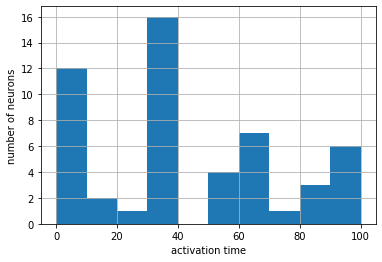

In [27]:
import pylab as pl

thres = 0.1
bools = df1_scale > thres
bools.sum().hist()
pl.xlabel("activation time")
pl.ylabel("number of neurons")

In [28]:
test = bools.sum()
print(type(test))
print(test[0])


<class 'pandas.core.series.Series'>
63


('block1_conv1', 0) block1_conv1


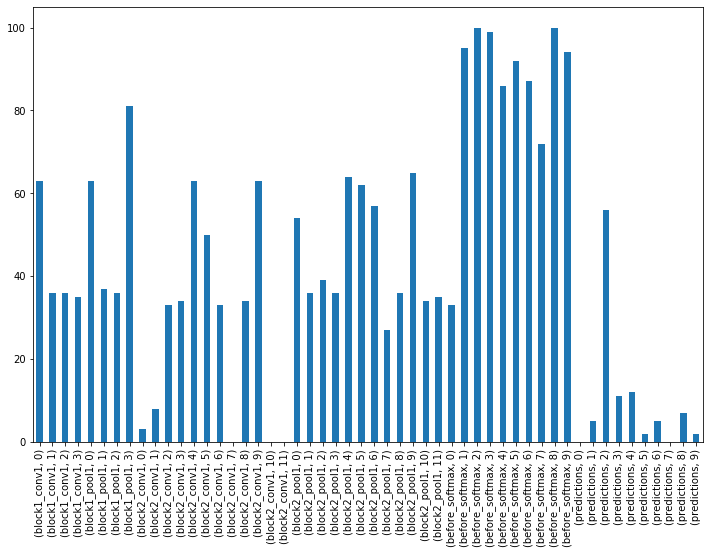

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
print(test.index[0],test.index[0][0])

fig, axes = plt.subplots(figsize=(12, 8))
test.plot(kind="bar")

In [31]:
temp, temp_scale = neuron_output(gen_img, model1, model_layer_dict1, args.threshold)
temp, temp_scale_mod = neuron_output(gen_img, model1, model_layer_dict1, args.threshold)
#temp_scale
temp_list = df1.columns
temp_list_mod = df1.columns


for i, layer in enumerate(temp_list):
  #print(i, layer)
  if layer[1] == 0:
    print(i, layer)
    if i > 0:
      temp_list_mod.insert(i, ("None", 0))
      temp_scale_mod.insert(i,0)

0 ('block1_conv1', 0)
4 ('block1_pool1', 0)
8 ('block2_conv1', 0)
20 ('block2_pool1', 0)
32 ('before_softmax', 0)
42 ('predictions', 0)


In [32]:
print(temp_list)
print(temp_list_mod)
print(temp_scale)
print(temp_scale_mod)

Index([  ('block1_conv1', 0),   ('block1_conv1', 1),   ('block1_conv1', 2),
         ('block1_conv1', 3),   ('block1_pool1', 0),   ('block1_pool1', 1),
         ('block1_pool1', 2),   ('block1_pool1', 3),   ('block2_conv1', 0),
         ('block2_conv1', 1),   ('block2_conv1', 2),   ('block2_conv1', 3),
         ('block2_conv1', 4),   ('block2_conv1', 5),   ('block2_conv1', 6),
         ('block2_conv1', 7),   ('block2_conv1', 8),   ('block2_conv1', 9),
        ('block2_conv1', 10),  ('block2_conv1', 11),   ('block2_pool1', 0),
         ('block2_pool1', 1),   ('block2_pool1', 2),   ('block2_pool1', 3),
         ('block2_pool1', 4),   ('block2_pool1', 5),   ('block2_pool1', 6),
         ('block2_pool1', 7),   ('block2_pool1', 8),   ('block2_pool1', 9),
        ('block2_pool1', 10),  ('block2_pool1', 11), ('before_softmax', 0),
       ('before_softmax', 1), ('before_softmax', 2), ('before_softmax', 3),
       ('before_softmax', 4), ('before_softmax', 5), ('before_softmax', 6),
       ('bef

In [0]:
xs = test.index
xs

for thres in thresholds:
#  for colm in df1_scale.columns:
#    bools = df
bools = df1_scale[df1_scale.columns[0]] > thresholds
print(thres)
print(bools, bools.sum())
#bools = df1_scale[df1_scale.columns[0]] > 0.1
#print(bools, bools.sum())

In [0]:
pd.options.display.float_format = '{:.3f}'.format
df1_scale

In [0]:
data_per_x1 = np.average(temp_per_nc1, axis=1)
data_per_x2 = np.average(temp_per_nc2, axis=1)
data_per_x3 = np.average(temp_per_nc3, axis=1)
std_per_x1 = np.std(temp_per_nc1, axis=1)
std_per_x2 = np.std(temp_per_nc2, axis=1)
std_per_x3 = np.std(temp_per_nc3, axis=1)

print(data_per_x1, std_per_x1, std_per_x2, std_per_x3)

In [0]:
data_num_x1 = np.average(temp_num_nc1, axis=1)
data_num_x2 = np.average(temp_num_nc2, axis=1)
data_num_x3 = np.average(temp_num_nc3, axis=1)
std_num_x1 = np.std(temp_num_nc1, axis=1)
std_num_x2 = np.std(temp_num_nc2, axis=1)
std_num_x3 = np.std(temp_num_nc3, axis=1)

print(data_num_x1, std_num_x1, std_num_x2, std_num_x3)

In [0]:
import matplotlib
import matplotlib.pyplot as plt
t = np.linspace(0, 10, 10)
fig = plt.figure(figsize=(20,7),dpi=60)
ax = fig.add_subplot(1,2,1)
plt.errorbar(t, data_per_x1, yerr=std_per_x1, marker="o", label="model1")
plt.errorbar(t, data_per_x2, yerr=std_per_x2, marker="s", label="model2")
plt.errorbar(t, data_per_x3, yerr=std_per_x3, marker="^", label="model3")
ax.legend(loc=0)
plt.legend(fontsize=18)
plt.title("neuron coverage", fontsize=18)
ax.set_xlabel('step', fontsize=18)
ax.set_ylabel('neuron coverage', fontsize=18)
plt.tick_params(labelsize=16)

ax = fig.add_subplot(1,2,2)
plt.errorbar(t, data_num_x1, yerr=std_num_x1, marker="o", label="model1:"+str(neuron_covered(model_layer_dict1)[1]))
plt.errorbar(t, data_num_x2, yerr=std_num_x2, marker="s", label="model2:"+str(neuron_covered(model_layer_dict2)[1]))
plt.errorbar(t, data_num_x3, yerr=std_num_x3, marker="^", label="model3:"+str(neuron_covered(model_layer_dict3)[1]))
ax.legend(loc=0)
plt.legend(fontsize=18)
plt.title("neuron coverage", fontsize=18)
ax.set_xlabel('step', fontsize=18)
ax.set_ylabel('# covered neuron ', fontsize=18)
plt.tick_params(labelsize=16)